In [1]:
# License: BSD
# Author: Sasank Chilamkurthy

from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

plt.ion()   # interactive mode

#### Load data
Lưu biến dict (key 'train' là tập train, ...)   
Không dùng dataset của torch.utils ....mà dùng datasets.ImageFolder của torchvision

In [2]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = 'hymenoptera_data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
# print(image_datasets)
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

#### visualize 1 vài bức hình
Một vài lưu ý:
+ Ở đây đầu tiên là xả cái chuẩn hóa phân phối đều ra 
+ Biểu diễn ảnh mà giá trị pixel là số nguyên: [0..255], số thực: [0..1]
+ Hàm clip dùng để giới hạn các giá trị của ma trận trong khoảng từ 0..1 (vì lúc xả chuẩn hóa có thể có sai số)

(228, 906, 3)


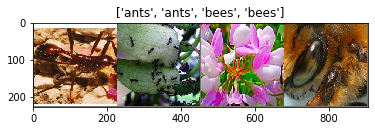

In [3]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    print(inp.shape)
    # print(inp)
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    # print(inp)
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

#### Train model
+ Mỗi epoch sẽ có train và validation   
+ Bật model.train() mục đích là để biết đường bật các phần như dropout,... ngược lại với model.eval(), vì ở đây dùng model có sẵn và các phần này được set trước
+ scheduler cho phase train là để căn chỉnh learning rate decay ....
+ Train luôn cái resnet
+ Mỗi epochs, tính toán validation accuracy sau đó lưu lại model có accuracy tốt nhất để inference (chạy test)

In [4]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            
        

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

#### Download pretrained model về
Đây là bài toán classification 2 lớp (kiến và ong) -> sửa output features của layer fc cuối là 2

In [5]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [6]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

Epoch 0/24
----------
train Loss: 0.6090 Acc: 0.6762
val Loss: 0.2205 Acc: 0.9216

Epoch 1/24
----------
train Loss: 0.5210 Acc: 0.7459
val Loss: 0.1749 Acc: 0.9412

Epoch 2/24
----------
train Loss: 0.5859 Acc: 0.7910
val Loss: 0.3068 Acc: 0.8497

Epoch 3/24
----------
train Loss: 0.4926 Acc: 0.8156
val Loss: 0.2734 Acc: 0.9020

Epoch 4/24
----------
train Loss: 0.3660 Acc: 0.8484
val Loss: 0.4916 Acc: 0.8170

Epoch 5/24
----------
train Loss: 0.6296 Acc: 0.7623
val Loss: 0.3124 Acc: 0.8954

Epoch 6/24
----------
train Loss: 0.7125 Acc: 0.7910
val Loss: 0.5136 Acc: 0.8889

Epoch 7/24
----------
train Loss: 0.6814 Acc: 0.8033
val Loss: 0.3034 Acc: 0.9020

Epoch 8/24
----------
train Loss: 0.6354 Acc: 0.8197
val Loss: 0.3162 Acc: 0.9085

Epoch 9/24
----------
train Loss: 0.4561 Acc: 0.8361
val Loss: 0.3117 Acc: 0.9085

Epoch 10/24
----------
train Loss: 0.4592 Acc: 0.8566
val Loss: 0.3809 Acc: 0.9020

Epoch 11/24
----------
train Loss: 0.3070 Acc: 0.8730
val Loss: 0.3114 Acc: 0.9020

Ep

#### Không train resnet
tắt phần required_grad của resnet params

In [7]:
model_conv = torchvision.models.resnet18(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

In [8]:
model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss: 0.6060 Acc: 0.6230
val Loss: 0.1966 Acc: 0.9346

Epoch 1/24
----------
train Loss: 0.4548 Acc: 0.8115
val Loss: 0.2102 Acc: 0.9216

Epoch 2/24
----------
train Loss: 0.4708 Acc: 0.7787
val Loss: 0.2002 Acc: 0.9216

Epoch 3/24
----------
train Loss: 0.3765 Acc: 0.8320
val Loss: 0.1680 Acc: 0.9542

Epoch 4/24
----------
train Loss: 0.4125 Acc: 0.7910
val Loss: 0.2260 Acc: 0.9085

Epoch 5/24
----------
train Loss: 0.3970 Acc: 0.8197
val Loss: 0.3992 Acc: 0.8431

Epoch 6/24
----------
train Loss: 0.6460 Acc: 0.7295
val Loss: 0.2543 Acc: 0.9085

Epoch 7/24
----------
train Loss: 0.3211 Acc: 0.8689
val Loss: 0.2015 Acc: 0.9412

Epoch 8/24
----------
train Loss: 0.2592 Acc: 0.8852
val Loss: 0.2144 Acc: 0.9412

Epoch 9/24
----------
train Loss: 0.3772 Acc: 0.8074
val Loss: 0.2389 Acc: 0.9216

Epoch 10/24
----------
train Loss: 0.2774 Acc: 0.8893
val Loss: 0.2103 Acc: 0.9477

Epoch 11/24
----------
train Loss: 0.3840 Acc: 0.8320
val Loss: 0.1969 Acc: 0.9412

Ep